In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from datetime import datetime
import pickle
import random

rng = np.random.default_rng(926834)

In [2]:
#labels helpers and processing
def pivot_df(df, id_col, ignore_cols=None):
    if not ignore_cols:
        ignore_cols = []
    date_cols = [x for x in df.columns if x not in [id_col] + ignore_cols]
    dfs = []
    for day in date_cols:
        day_df = df[[id_col, day]].rename({day: 'snowpack'}, axis=1)
        day_df['date'] = day
        dfs.append(day_df)
    return pd.concat(dfs)

def daynum_gen(date_time):
    '''converts date time objects to filename'''
    date_time = datetime.fromisoformat(date_time)
    doy = date_time.timetuple().tm_yday
    year = date_time.year
    return str(year) + '{:03d}'.format(doy)

# Get ordered elevation training data
def add_elevation(order, modis):
    order = pd.DataFrame({'modis_idx': order, 'order': [x for x in range(len(order))]})
    order['station_id'] = order['modis_idx'].apply(lambda x: '-'.join(x.split('-')[:-1]))
    order = order.merge(elev_order).sort_values('order')
    ordered_elev = elevation[order['DEM_order'].to_list(), :, :]
    dim = ordered_elev.shape

    return np.concatenate([modis, ordered_elev.reshape(dim[0], 1, dim[1], dim[2])], axis=1)

### Load data

In [3]:
base_path = "C:/Users/Matt/Dropbox/SnowComp/"
path1 = base_path+"ModisSnowImagesT.npy"
path2 = base_path+"ModisSnowImagesA.npy"
path3 = base_path+"ModisSnowImages_subT.npy"
path4 = base_path+"ModisSnowImages_subA.npy"

#submission small
path5 =base_path +"ModisSnowImages_subAT_small.npy"
path6 =base_path +"ModisSnowImages_AT_small.npy"

#train_features
path7 =base_path + "ModisSnowImages_trainfeat_T.npy"
path8 =base_path + "ModisSnowImages_trainfeat_A.npy"

#test_features
path9 =base_path + "ModisSnowImages_testfeat_T.npy"
path10=base_path + "ModisSnowImages_testfeat_A.npy"

In [4]:
#load cell ids, note Ts are correct, As are actual daynums 
path_id = "C:/Users/Matt/Dropbox/SnowComp/cell_snow_idsT.pkl"
with open(path_id, 'rb') as handle:
    cell_ids = pickle.load( handle)

path_id = "C:/Users/Matt/Dropbox/SnowComp/cell_snow_ids_trainfeat.pkl"
with open(path_id, 'rb') as handle:
    cell_ids_train = pickle.load(handle)
    
path_id = "C:/Users/Matt/Dropbox/SnowComp/cell_snow_ids_testfeat.pkl"
with open(path_id, 'rb') as handle:
    cell_ids_test = pickle.load( handle)

In [5]:
#load elevation data
DEM_PATH = "C:/Users/Matt/Dropbox/SnowComp/Elevation/"

elevation = np.load(DEM_PATH + 'elevations.npy')
elev_order = pd.read_csv(DEM_PATH + 'order.csv')\
    .rename({'DEM_order': 'station_id'}, axis=1)
elev_order['DEM_order'] = [x for x in range(len(elev_order))]

elevation = np.swapaxes(elevation, 1, 2)

In [6]:
# #Assemble submission dataset
# sub_dataT = np.load(path3) #be careful about memory, this is about 25-30 gigs ram
# sub_dataA = np.load(path4)

# sub_dataset = np.concatenate((sub_dataT[:,0:1,:,:],sub_dataA[:,0:1,:,:]), axis = 1)
# sub_dataset = sub_dataset/255
# np.save(path5,sub_dataset)

# sub_dataset = torch.Tensor(sub_dataset)
# del sub_dataT, sub_dataA

#### Read in and process `train_label` data

In [7]:
train_y = pd.read_csv("C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/train_labels.csv")
train_y = pivot_df(train_y, 'cell_id').dropna()
train_y['date']=train_y['date'].map(daynum_gen)

#sort train_y so it has correct order before stripping labels
sorter = [idx +"-" +date for  idx, date  in cell_ids]
# with open(base_path + "train_idorder.pkl", 'wb') as handle:
#     pickle.dump(sorter, handle)

train_y['idx'] = train_y['cell_id'] +"-"+train_y['date']
train_y = train_y.set_index('idx')
train_y = train_y.loc[sorter]

In [8]:
#combine Aqua and Terra DSs
train_dataT = np.load(path1)
train_dataA = np.load(path2)

dataset = np.concatenate((train_dataT[:,0:1,:,:],train_dataA[:,0:1,:,:]), axis = 1)
# dataset = np.concatenate((train_dataT[:,(0,4),:,:],train_dataA[:,(0,4),:,:]), axis = 1)
# dataset = np.concatenate((train_dataT,train_dataA), axis = 1)

dataset= dataset/255
dataset = add_elevation(sorter, dataset)
START_D = dataset.shape[1]
# np.save(path6,dataset)

del train_dataT
del train_dataA

#### Read in and order `train_features` data 

In [9]:
train_feat = pd.read_csv("C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/ground_measures_train_features.csv")
train_feat = train_feat.rename(columns={"Unnamed: 0":"cell_id"})
train_feat = pivot_df(train_feat, 'cell_id').dropna()
train_feat['date']=train_feat['date'].map(daynum_gen)

#sort train_feat so it has correct order before stripping labels
sorter = [idx +"-" +date for  idx, date  in cell_ids_train]
# with open(base_path + "trainfeat_idorder.pkl", 'wb') as handle:
#     pickle.dump(sorter, handle)

train_feat['idx'] = train_feat['cell_id'] +"-"+train_feat['date']
train_feat = train_feat.set_index('idx')
train_feat = train_feat.loc[sorter]

In [10]:
#combine Aqua and Terra DSs
train_feat_dataT = np.load(path7)
train_feat_dataA = np.load(path8)

dataset_temp = np.concatenate((train_feat_dataT[:,0:1,:,:],train_feat_dataA[:,0:1,:,:]), axis = 1)
# dataset_temp = np.concatenate((train_feat_dataT[:,(0,4),:,:],train_feat_dataA[:,(0,4),:,:]), axis = 1)
# dataset_temp = np.concatenate((train_feat_dataT,train_feat_dataA), axis = 1)

dataset_temp= dataset_temp/255
dataset_temp = add_elevation(sorter, dataset_temp)
# np.save(path6,dataset_temp)

del train_feat_dataT, train_feat_dataA

#### Read in and order `test_features` data

In [11]:
y_test = pd.read_csv("C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/ground_measures_test_features.csv")
y_test = y_test.rename(columns={"Unnamed: 0":"cell_id"})
y_test = pivot_df(y_test, 'cell_id').dropna()
y_test['date']=y_test['date'].map(daynum_gen)

#sort train_feat so it has correct order before stripping labels
sorter = [idx +"-" +date for  idx, date  in cell_ids_test]
with open(base_path + "testfeat_idorder.pkl", 'wb') as handle:
    pickle.dump(sorter, handle)

y_test['idx'] = y_test['cell_id'] +"-"+y_test['date']
y_test = y_test.set_index('idx')
y_test = y_test.loc[sorter]

In [12]:
#combine Aqua and Terra DSs
test_feat_dataT = np.load(path9)
test_feat_dataA = np.load(path10)

dataset_test = np.concatenate((test_feat_dataT[:,0:1,:,:],test_feat_dataA[:,0:1,:,:]), axis = 1)
# dataset_temp = np.concatenate((test_feat_dataT[:,(0,4),:,:],test_feat_dataA[:,(0,4),:,:]), axis = 1)
# dataset_temp = np.concatenate((test_feat_dataT,test_feat_dataA), axis = 1)

dataset_test= dataset_test/255
dataset_test= add_elevation(sorter, dataset_test)
# np.save(path6,dataset_temp)

del test_feat_dataT, test_feat_dataA

Holdout 15% of `train_labels` and smoosh everything together

In [13]:
#holdout 
mask = rng.random(len(dataset)) < 0.85

test_grid = dataset[~mask]
dataset = dataset[mask]
test_grid_y = train_y[~mask]
train_y = train_y[mask]

print(dataset.shape)
print(test_grid.shape)
print(test_grid_y.shape)
print(train_y.shape)

(77718, 3, 21, 21)
(13772, 3, 21, 21)
(13772, 3)
(77718, 3)


In [14]:
#training data
train_dataset = np.concatenate((dataset,
                   dataset_temp), axis = 0)
train_y = pd.concat((train_y, train_feat),
                    axis = 0)

train_y = train_y.reset_index(drop=True)
del dataset_temp, train_feat

#shuffle
p =rng.permutation(len(train_dataset))
train_y = train_y.loc[p]
train_dataset = train_dataset[p]

In [15]:
#test data
dataset_test = np.concatenate((dataset_test, test_grid),
                              axis = 0) 
y_test = pd.concat((y_test, test_grid_y),
                    axis = 0)

y_test = y_test.reset_index(drop=True)
del test_grid_y, test_grid

#shuffle
p =rng.permutation(len(dataset_test))
y_test = y_test.loc[p]
dataset_test = dataset_test[p]

In [16]:
data_path = "C:/Users/Matt/Dropbox/SnowComp/FinalData/"

train_y.to_csv(data_path + "train_y.csv", index = False)
y_test.to_csv(data_path + "test_y.csv", index = False)

np.save(data_path + "train_dataset.npy", train_dataset)
np.save(data_path + "test_datast.npy", dataset_test)

## Translate to Pytorch datatypes and validation

Redefine train and testing datasets 

In [17]:
#@title Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [18]:
#@title split training and testing
training_data = train_dataset
testing_data = dataset_test
train_rows = len(training_data)
test_rows = len(testing_data)

In [19]:
#@title Get data loaders
test_x, test_y = dataset_test, np.array(y_test['snowpack'])
test_x, test_y = torch.Tensor(test_x), torch.Tensor(test_y)
test_dataset = TensorDataset(test_x,test_y)
test_loader = DataLoader(test_dataset, batch_size = 256)

mini_x, mini_y = train_dataset, np.array(train_y['snowpack'])
mini_x, mini_y = torch.Tensor(mini_x), torch.Tensor(mini_y)

mini_dataset = TensorDataset(mini_x,
                              mini_y)
mini_loader = DataLoader(mini_dataset, batch_size=256)

# CNN

In [20]:
#@title Define simple CNN
# From: https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html
# Also used: https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

START_HW = 21

class Net(nn.Module):

    def _conv_calc(self, in_dim, pad, stride, k):
        out = int(np.floor((in_dim + 2 * pad - (k - 1) - 1) / stride + 1))
        return out

    def __init__(self, cdim1, cdim2,cdim3, kernel_sz, dropout,
                 ldim, print_dim = True):
        super(Net, self).__init__()
        
        #first layer
        self.conv1 = nn.Conv2d(START_D, cdim1, kernel_sz, 1)
        self.avgpool = nn.AvgPool2d(3, stride= 1)
        
        c1_dim = self._conv_calc(START_HW, 0, 1, kernel_sz)
        mp0_dim = self._conv_calc(c1_dim, 0, 1, 3)
        
        #second layer
        self.conv2 = nn.Conv2d(cdim1, cdim2, kernel_sz, 1)
        c2_dim = self._conv_calc(mp0_dim, 0, 1, kernel_sz)
        mp1_dim = self._conv_calc(c2_dim, 0, 1, 3)
        
        
        #third layer
        self.conv3 = nn.Conv2d(cdim2, cdim3, kernel_sz, 1)
        c3_dim = self._conv_calc(mp1_dim, 0, 1, kernel_sz)
        mp2_dim = self._conv_calc(c3_dim, 0, 1, 3)
        
        #fourth layer
        flattened_dim = cdim3 * mp2_dim * mp2_dim
        self.fc1 = nn.Linear(flattened_dim, ldim)
        self.fc2 = nn.Linear(ldim, 1)

        #extras
        self.dropout1 = nn.Dropout2d(dropout)
        self.dropout2 = nn.Dropout2d(dropout*2)
        self.BatchNorm1 = nn.BatchNorm2d(cdim1)
        self.BatchNorm3 = nn.BatchNorm2d(cdim3)
        
        if print_dim:
            print('c1 dim:', c1_dim)
            print('mp0 dim:', mp0_dim)
            print('c2 dim:', c2_dim)
            print('mp1 dim:', mp1_dim)
            print('c3 dim:', c3_dim)
            print('mp2 dim:', mp2_dim)
            print('flattened_dim',flattened_dim)
        
        
    def forward(self, x):
        #first layer
        x = self.conv1(x)
#         x = torch.tanh(x)
        x = F.relu(x)
        x = self.BatchNorm1(x)
        x = self.avgpool(x)
        
        #second layer
        x = self.dropout1(x)
        x = self.conv2(x)
#         x = torch.tanh(x)
        x = F.relu(x)
        x = self.avgpool(x)
        
        #third layer
        x = self.dropout2(x)
        x = self.conv3(x)
        x = torch.tanh(x)
        x = F.relu(x)
        x = self.BatchNorm3(x)
        x = self.avgpool(x)
        
        #fourth layer
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        
        output = self.fc2(x)
        return output

    




In [21]:
#@title Helpers to get predictions and accuracy
def predict(cnn, x, as_numpy=False):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    cnn.eval()
    x =x.type(torch.FloatTensor).to(device)
    output = cnn(x)
    if as_numpy:
        output = output.flatten().cpu().detach().numpy() #detach removes gradients (bad)
        
    cnn.train()
    return output.squeeze()

def get_accuracy(cnn, x, y):
#     y = torch.from_numpy(y).to(device)
    outputs = predict(cnn, x,as_numpy = False)
    
#     print(y.shape, outputs.shape)
    loss = ((y-outputs)**2).sum()
    return round(loss.item(), 6)



In [22]:
#@title Setup net
cdim1=90; cdim2=30; cdim3 =15; kernel_sz=3; dropout=0.13; ldim=50; lrate = 0.0001
my_nn = Net(cdim1=cdim1, cdim2=cdim2,cdim3 =cdim3, kernel_sz=kernel_sz, dropout=dropout, ldim=ldim)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

my_nn.to(device)
optimizer = optim.Adam(my_nn.parameters(), lr=lrate)
criterion = nn.MSELoss(reduction = 'sum')

writer = SummaryWriter('runs/cnn_alldata')
write_index = 0

c1 dim: 19
mp0 dim: 17
c2 dim: 15
mp1 dim: 13
c3 dim: 11
mp2 dim: 9
flattened_dim 1215


In [23]:
N_EPOCHS = 200

test_loss = []
train_loss = []

#@title Run net
for epoch in tqdm(range(N_EPOCHS)):
    running_loss = 0.0
    for i, data in enumerate(mini_loader, 0):
        optimizer.zero_grad()
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = my_nn(inputs).squeeze()
#         print(outputs.shape, labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
#         for name, param in my_nn.named_parameters():
#             print(name, param.grad.abs().sum())

        running_loss += loss.item()
        if (i + 1) % 100 == 0:
            writer.add_scalar('Loss/train', running_loss , write_index)
        write_index += 1

#     val_acc = get_accuracy(my_nn, mini_x, mini_y)
    train_loss.append(running_loss/train_rows)
    writer.add_scalar('Acc/val', train_loss[-1], write_index)
    
    #calculate test loss.
    with torch.no_grad():
        
        running_tar_loss = 0
        for data, target in test_loader:
            running_tar_loss += get_accuracy(my_nn, data, target.to(device))


        test_loss.append(running_tar_loss / test_rows)
        writer.add_scalar('Test MSE', test_loss[-1], write_index)

    print(epoch, '/', N_EPOCHS,
          'complete, train:', round(np.sqrt(train_loss[-1]), 4),
          "test:", round(np.sqrt(test_loss[-1]), 4) )
            
            
            
    
writer.close()
print('Finished Training')
# 10.1, 9.4 best
# 9.9, 8.5 best with DEM @400

  0%|          | 0/200 [00:00<?, ?it/s]

0 / 200 complete, train: 13.6132 test: 11.9311
1 / 200 complete, train: 13.221 test: 11.5631
2 / 200 complete, train: 12.9863 test: 11.1985
3 / 200 complete, train: 12.7885 test: 10.8659
4 / 200 complete, train: 12.6259 test: 10.7928
5 / 200 complete, train: 12.5121 test: 10.5905
6 / 200 complete, train: 12.4233 test: 10.6476
7 / 200 complete, train: 12.3431 test: 10.5022
8 / 200 complete, train: 12.2891 test: 10.2967
9 / 200 complete, train: 12.2385 test: 10.3836
10 / 200 complete, train: 12.1726 test: 10.2687
11 / 200 complete, train: 12.1225 test: 10.4767
12 / 200 complete, train: 12.098 test: 10.4923
13 / 200 complete, train: 12.0312 test: 10.1359
14 / 200 complete, train: 12.0045 test: 10.6666
15 / 200 complete, train: 11.9769 test: 10.2224
16 / 200 complete, train: 11.931 test: 10.0128
17 / 200 complete, train: 11.9042 test: 10.0211
18 / 200 complete, train: 11.871 test: 9.9685
19 / 200 complete, train: 11.8343 test: 9.8875
20 / 200 complete, train: 11.7944 test: 9.8703
21 / 200 

174 / 200 complete, train: 10.5915 test: 9.0549
175 / 200 complete, train: 10.5965 test: 9.0796
176 / 200 complete, train: 10.5986 test: 9.1192
177 / 200 complete, train: 10.6005 test: 9.1018
178 / 200 complete, train: 10.578 test: 8.9784
179 / 200 complete, train: 10.5593 test: 9.1957
180 / 200 complete, train: 10.5828 test: 9.0182
181 / 200 complete, train: 10.5566 test: 9.0429
182 / 200 complete, train: 10.5686 test: 9.0388
183 / 200 complete, train: 10.5736 test: 9.0673
184 / 200 complete, train: 10.5562 test: 8.9801
185 / 200 complete, train: 10.5601 test: 9.0765
186 / 200 complete, train: 10.5661 test: 8.9784
187 / 200 complete, train: 10.5475 test: 9.0333
188 / 200 complete, train: 10.5382 test: 8.9829
189 / 200 complete, train: 10.5448 test: 8.9914
190 / 200 complete, train: 10.5414 test: 8.9862
191 / 200 complete, train: 10.5407 test: 9.019
192 / 200 complete, train: 10.5321 test: 8.9955
193 / 200 complete, train: 10.5455 test: 8.9941
194 / 200 complete, train: 10.5407 test: 8

In [24]:
torch.cuda.empty_cache()


### Checking accuracy

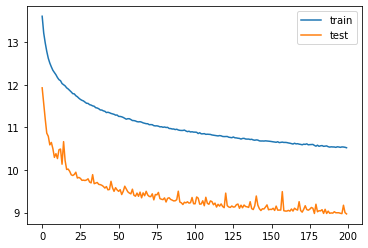

In [25]:
path = "C:/Users/Matt/Dropbox/SnowComp/RunGraphs/" 

suffix = "_" + \
    str(cdim1)+ "_" + str(cdim2)+ "_" +str(cdim3)+ "_" + str(kernel_sz)+ \
    "_" + str(dropout)+ "_" + str(ldim)+ "_" + str(epoch) +"_" + str(lrate)

plt.plot(range(epoch+1), np.sqrt(train_loss), label ="train")
plt.plot(range(epoch+1), np.sqrt(test_loss), label ="test")
plt.legend()
plt.savefig(path +"converge_alldata" + suffix+ ".png")

## Save Model and Predictions

In [26]:
pred_all = True

Rerun model on full dataset

In [27]:
if pred_all:
    del mini_x, mini_dataset, mini_loader

    full_x = np.concatenate((train_dataset, dataset_test), axis = 0)
    full_y = pd.concat((train_y, y_test), axis= 0)

    #shuffle
    full_y = full_y.reset_index(drop=True)

    p = rng.permutation(len(full_x))
    full_y = full_y.loc[p]
    full_x = full_x[p]

    full_y_og = full_y.copy()

In [28]:
if pred_all:
    full_y = np.array(full_y['snowpack'])

    full_x, full_y = torch.Tensor(full_x), torch.Tensor(full_y)
    full_dataset = TensorDataset(full_x, full_y)
    full_loader = DataLoader(full_dataset, batch_size=258)

    # del train_dataset, dataset_test, train_y, y_test

In [29]:
if pred_all:
    #@title Setup net
    my_nn = Net(cdim1=cdim1, cdim2=cdim2,cdim3 =cdim3,
                kernel_sz=kernel_sz, dropout=dropout, ldim=ldim)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    my_nn.to(device)

    optimizer = optim.Adam(my_nn.parameters(), lr=lrate)
    criterion = nn.MSELoss(reduction = 'sum')

c1 dim: 19
mp0 dim: 17
c2 dim: 15
mp1 dim: 13
c3 dim: 11
mp2 dim: 9
flattened_dim 1215


In [30]:
if pred_all:
    train_loss = []

    #@title Run net
    for epoch in tqdm(range(int(N_EPOCHS*1.1))):
        running_loss = 0.0
        for i, data in enumerate(full_loader, 0):
            optimizer.zero_grad()
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = my_nn(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss.append(running_loss/train_rows)
        print(epoch, '/', N_EPOCHS,
              'complete, train:', round(np.sqrt(train_loss[-1]), 4),
              "test:", round(np.sqrt(test_loss[-1]), 4) )
        
    torch.cuda.empty_cache()

  0%|          | 0/220 [00:00<?, ?it/s]

0 / 200 complete, train: 14.8862 test: 8.968
1 / 200 complete, train: 14.4546 test: 8.968
2 / 200 complete, train: 14.2521 test: 8.968
3 / 200 complete, train: 14.018 test: 8.968
4 / 200 complete, train: 13.8382 test: 8.968
5 / 200 complete, train: 13.6869 test: 8.968
6 / 200 complete, train: 13.5872 test: 8.968
7 / 200 complete, train: 13.4887 test: 8.968
8 / 200 complete, train: 13.4104 test: 8.968
9 / 200 complete, train: 13.3407 test: 8.968
10 / 200 complete, train: 13.2911 test: 8.968
11 / 200 complete, train: 13.2213 test: 8.968
12 / 200 complete, train: 13.1648 test: 8.968
13 / 200 complete, train: 13.121 test: 8.968
14 / 200 complete, train: 13.0828 test: 8.968
15 / 200 complete, train: 13.0326 test: 8.968
16 / 200 complete, train: 12.9901 test: 8.968
17 / 200 complete, train: 12.9399 test: 8.968
18 / 200 complete, train: 12.9166 test: 8.968
19 / 200 complete, train: 12.8678 test: 8.968
20 / 200 complete, train: 12.85 test: 8.968
21 / 200 complete, train: 12.8116 test: 8.968
22

178 / 200 complete, train: 11.4139 test: 8.968
179 / 200 complete, train: 11.4228 test: 8.968
180 / 200 complete, train: 11.3987 test: 8.968
181 / 200 complete, train: 11.3927 test: 8.968
182 / 200 complete, train: 11.3964 test: 8.968
183 / 200 complete, train: 11.4015 test: 8.968
184 / 200 complete, train: 11.3889 test: 8.968
185 / 200 complete, train: 11.4044 test: 8.968
186 / 200 complete, train: 11.3836 test: 8.968
187 / 200 complete, train: 11.3788 test: 8.968
188 / 200 complete, train: 11.3677 test: 8.968
189 / 200 complete, train: 11.3804 test: 8.968
190 / 200 complete, train: 11.3748 test: 8.968
191 / 200 complete, train: 11.372 test: 8.968
192 / 200 complete, train: 11.3543 test: 8.968
193 / 200 complete, train: 11.3588 test: 8.968
194 / 200 complete, train: 11.3543 test: 8.968
195 / 200 complete, train: 11.3545 test: 8.968
196 / 200 complete, train: 11.3551 test: 8.968
197 / 200 complete, train: 11.3558 test: 8.968
198 / 200 complete, train: 11.3413 test: 8.968
199 / 200 comp

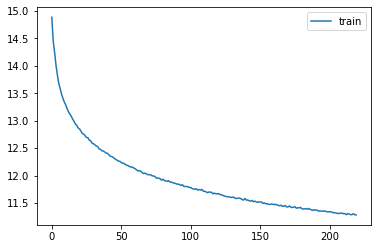

In [31]:
if pred_all:
    path = "C:/Users/Matt/Dropbox/SnowComp/RunGraphs/" 

    suffix = "_" + \
        str(cdim1)+ "_" + str(cdim2)+ "_" +str(cdim3)+ "_" + str(kernel_sz)+ \
        "_" + str(dropout)+ "_" + str(ldim)+ "_" + str(epoch) +"_" + str(lrate) 

    plt.plot(range(epoch+1), np.sqrt(train_loss), label ="train")
    plt.legend()
    plt.savefig(path +"full" + suffix+ ".png")

### Save predictions

In [32]:
if pred_all:
    #sort train_feat so it has correct order before stripping labels
    path_id = "C:/Users/Matt/Dropbox/SnowComp/cell_snow_ids_subT.pkl"
    with open(path_id, 'rb') as handle:
        cell_ids_sub = pickle.load( handle)
        
    sub_sorter = [idx +"-" +date for  idx, date  in cell_ids_sub]

    sub_dataset = np.load(path5)
    sub_dataset = add_elevation(sub_sorter, sub_dataset)
    
    

In [33]:
if pred_all:
    my_nn.eval()
    my_nn.to('cpu')

    torch.save(my_nn.state_dict(), path +"model"+suffix)
    
    vals = []
    for inputs, _ in full_loader:
        with torch.no_grad():
            vals.append(my_nn(inputs).detach().numpy())
    vals =  np.concatenate(vals, axis = 0)       
    
    path_preds = "C:/Users/Matt/Dropbox/SnowComp/preds/" 
    np.save(path_preds+"preds.npy", vals)
    full_y_og.to_csv(path_preds+"yvals.csv")
    
    #Predict and save on submission data
    vals_sub = []
    
    sub_dataset = torch.Tensor(sub_dataset)
    sub_ds = TensorDataset(sub_dataset)
    sub_loader = DataLoader(sub_ds, batch_size=5000)

    with torch.no_grad():
        for images in sub_loader:
            vals_sub.append(my_nn(images[0]).detach().numpy()) 

    vals_sub = np.concatenate(vals_sub, axis = 0)        
    np.save(path_preds+"subpred.npy", vals_sub)
    
    #calculate image quality
    image_qual = full_x.detach().numpy()
    image_qual = np.sum(image_qual, axis= (1,2,3))
    np.save(path_preds +"image_qual_train.npy", image_qual)
    
    image_qual = np.sum(sub_dataset.detach().numpy(), axis= (1,2,3))
    np.save(path_preds +"image_qual_sub.npy", image_qual)    
    

In [34]:
path_preds = "C:/Users/Matt/Dropbox/SnowComp/preds/" 
sub_preds = np.load(path_preds+"subpred.npy")
sub_preds.shape

(516762, 1)

In [ ]:
plt.hist(sub_preds)

## Things to check

1. Accuracy measures are right
2. Check missing value

### TODO:
- Add test set/cv
- Batchnorm?
- CNN benchmark